In [2]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

In [6]:
Random.seed!(123)

function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.001, 0.001]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.001, 0.001]))
    C = [0.5 0.5; 0.5 0.1; 0.1 0.1]
    d = [0.5, 0.5, 0.5]
    D = Matrix(Diagonal([0., 0., 0.]))
    b = ones(T, 2) * 0.1

    plds = PoissonLDS(A=A, C=C, Q=Q, D=D, b=b, d=d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 3)
    return plds, x, y
end

plds, x, y = toy_PoissonLDS()

model = SSM.PoissonPCA(;latent_dim=2, obs_dim=3)
lls = fit!(model, y[:, :, 1], 100)

b = ones(100, 2) * 0.5
plds.A = Matrix{Float64}([0.1 -0.1; 0.1 0.1])
plds.Q = Matrix{Float64}([1 0; 0 1])
plds.x0 = [1.0, -1.0]
plds.p0 = Matrix{Float64}([1 0; 0 1])
plds.b = b;
plds.C = model.C
plds.d = exp.(model.log_b)

Fitting Poisson PCA... 100%|█████████████████████████████| Time: 0:01:10


3-element Vector{Float64}:
 2.226767454000686
 0.7014426010417005
 1.0161471582556048

In [8]:
lls = SSM.fit!(plds, y, 100)

Iteration: 1 Log-likelihood: 1794.416813586007
Iteration: 2 Log-likelihood: 2022.030744615945
Iteration: 3 Log-likelihood: 2121.7020800402697
Iteration: 4 Log-likelihood: 2178.0185056529845
Iteration: 5 Log-likelihood: 2220.4501807709403
Iteration: 6 Log-likelihood: 2255.990936806126
Iteration: 7 Log-likelihood: 2287.9598676793157
Iteration: 8 Log-likelihood: 2317.9055291475643
Iteration: 9 Log-likelihood: 2346.513193862721
Iteration: 10 Log-likelihood: 2374.067400246082
Iteration: 11 Log-likelihood: 2400.6812634462676
Iteration: 12 Log-likelihood: 2426.401868385863
Iteration: 13 Log-likelihood: 2451.255040865213
Iteration: 14 Log-likelihood: 2475.262844826715
Iteration: 15 Log-likelihood: 2498.449588748701
Iteration: 16 Log-likelihood: 2520.842853232555
Iteration: 17 Log-likelihood: 2542.472895240505
Iteration: 18 Log-likelihood: 2563.3714465317057
Iteration: 19 Log-likelihood: 2583.570457832294
Iteration: 20 Log-likelihood: 2603.101121310491
Iteration: 21 Log-likelihood: 2621.9931955

In [ ]:
plds.C = model.C

In [69]:
smoothed_x, smoothed_p = SSM.smooth(plds, y)

([0.948760419975133 0.20607392220856235; 1.2277451231486372 -0.018974444929809424; … ; 0.8778107504950577 0.33085973963837206; 0.9371815062016227 0.19739347307443766;;; 0.923286554879857 0.23362363342595266; 1.2009031142407427 0.049200618883142935; … ; 0.885835724952361 0.39683699162144753; 0.964070146210604 0.2423779711725131;;; 0.9355896534613016 0.23152428586783744; 1.1537756287521408 0.15532280098437648; … ; 0.5081389140904424 0.5145177731217893; 0.4821046843409935 0.4592126450778267], [0.0014405539346659033 -0.0007147266888990002; 0.011704533680873559 -0.004276555686083564; … ; 0.026251676593926337 -0.015387699496038099; 0.029500446548045144 -0.012562283563263846;;; -0.0007147266888990001 0.0006474669736414614; -0.004276555686083561 0.002193952525553626; … ; -0.015387699496038104 0.011470061636383479; -0.012562283563263851 0.00764867821648012;;;; 0.0014482762850915746 -0.0007257914605773214; 0.009017227857115536 -0.0034129034378404; … ; 0.02756186131784402 -0.017322624077137524; 0

In [75]:
model.C

3×2 Matrix{Float64}:
  0.119353   -0.127775
  0.0754284  -0.0910139
 -0.145552    0.533711

In [78]:
plds.d

3-element Vector{Float64}:
 -7.93579700545287
  7.009471988439042
 -6.869675591048945

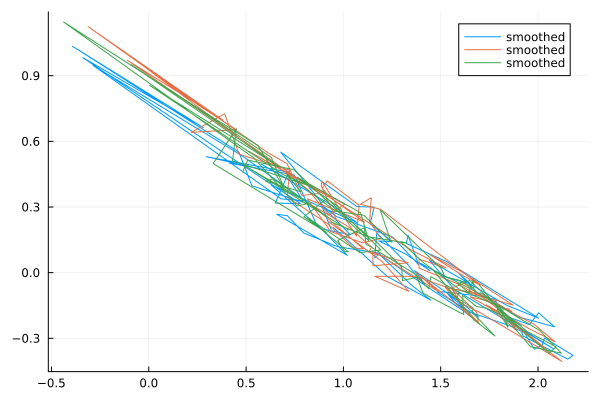

In [70]:
plot(smoothed_x[:, 1, :], smoothed_x[:, 2, :], label="smoothed")

In [15]:
x_sm, p_sm, ptt1 = SSM.smooth(plds, y)
obj(A) = A -> -SSM.loglikelihood(x_sm, PoissonLDS(A=A, C=plds.C, Q=plds.Q, D=plds.D, b=plds.b, d=plds.d, x0=plds.x0, p0=plds.p0, refractory_period=plds.refractory_period, obs_dim=plds.obs_dim, latent_dim=plds.latent_dim), y)

res = optimize(obj(plds.A), plds.A, LBFGS(), autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     -1.596027e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.83e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.93e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.58e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.00e-07 ≰ 0.0e+00
    |g(x)|                 = 9.86e-14 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    11
    ∇f(x) calls:   11


In [18]:
# plds.A = res.minimizer


([1.1927212552120057 -1.311984617368557; 1.8417505372564464 -1.161470727576739; … ; -3.6051027147639756 2.8899855895623703; -3.5237142706228406 2.656333530404481;;; 0.38674315009349197 -1.8336993915910529; 1.8259138489380906 -1.3550888906217329; … ; -3.290319706799983 2.850391099150769; -3.2225821890050477 2.6531995617270407;;; 0.2123528176500199 -0.89745754063602; 0.5892660174656553 -0.4551282698412678; … ; -6.2514876480088875 3.3061711961805615; -6.550675428990746 2.7652484579932293], [0.39246209361185863 -0.12329597041065651; 0.4366713711792606 -0.2504134240295909; … ; 1.7284748258389444 -1.3645612527752498; 2.042208110803351 -1.5677355544501999;;; -0.1321870513272105 0.6039646535333929; -0.24575445660243503 0.737666155154776; … ; -0.804066805782049 1.6365381544382074; -1.2607247565367323 2.4040591760356786;;;; 0.4490055819254837 -0.08954819561308092; 0.4497123743187668 -0.24742331259215505; … ; 1.6412599575955806 -1.3317660338954598; 1.9435155906031834 -1.529531837773963;;; -0.1029

In [8]:
E_z, E_zz, E_zz_prev, x_sm, p_sm = SSM.E_Step(plds, y)
SSM.M_Step!(plds, E_z, E_zz, E_zz_prev, x_sm, y)

3-element Vector{Float64}:
 0.36432358028866
 0.5024235669524973
 0.5485808655141897

In [12]:
plds.A

2×2 Matrix{Float64}:
 0.91781   -0.0786126
 0.051594   0.971211

In [9]:
x_sm, p_sm, ptt1 = SSM.smooth(plds, y[1:3, :, 1])
H, main, super, sub = SSM.Hessian(x_sm[1:3, :, 1], plds, y[1:3, :, 1])

([-5.306496604136227 -1.3272480653397214 … 0.0 0.0; -1.3272480653397212 -3.4745199791164487 … 0.0 0.0; … ; 0.0 0.0 … -4.843783311160489 -1.7684532002236533; 0.0 0.0 … -1.7684532002236533 -2.725827757349074], [[-5.306496604136227 -1.3272480653397214; -1.3272480653397212 -3.4745199791164487], [-5.138766123352401 -1.2745022000387318; -1.2745022000387323 -3.255962332104459], [-4.843783311160489 -1.7684532002236533; -1.7684532002236533 -2.725827757349074]], [[1.2988840241830326 0.2831640590695201; 0.11831007962257777 1.2466003016565577], [1.2988840241830326 0.2831640590695201; 0.11831007962257777 1.2466003016565577]], [[1.2988840241830326 0.11831007962257777; 0.2831640590695201 1.2466003016565577], [1.2988840241830326 0.11831007962257777; 0.2831640590695201 1.2466003016565577]])

In [10]:
pinv(-H)

6×6 Matrix{Float64}:
  0.232306   -0.111608    0.0806965  -0.0713982   0.0376815  -0.0487165
 -0.111608    0.411471   -0.0865361   0.234053   -0.0698252   0.143351
  0.0806965  -0.0865361   0.280917   -0.181937    0.118733   -0.131054
 -0.0713982   0.234053   -0.181937    0.5936     -0.165766    0.360116
  0.0376815  -0.0698252   0.118733   -0.165766    0.337313   -0.282316
 -0.0487165   0.143351   -0.131054    0.360116   -0.282316    0.701098

In [11]:
ptt1 = SSM.block_tridiagonal_inverse(-sub, -main, -super)

([0.23230577692013157 -0.11160829304446732; 0.28091697316136244 -0.18193683620129933; 0.3373130635806515 -0.2823161546005771;;; -0.11160829304446729 0.4114708983224863; -0.18193683620129927 0.5936002756005954; -0.28231615460057713 0.7010984081679166], [0.08069645636548961 -0.07139823012491288; 0.11873288626032558 -0.1310539436047723;;; -0.08653610364222208 0.23405261409912242; -0.16576582689396976 0.36011571677848525])

In [12]:
ptt1[1][1, :, :]

2×2 Matrix{Float64}:
  0.232306  -0.111608
 -0.111608   0.411471

In [13]:
ptt1[2][2, :, :]

2×2 Matrix{Float64}:
  0.118733  -0.165766
 -0.131054   0.360116

In [11]:
main = [ptt1[1][i, :, :] for i in 1:3]
sub = [ptt1[2][i, :, :] for i in 1:2]
super = [permutedims(ptt1[2][i, :, :]) for i in 1:2]

H_inv = Matrix(SSM.block_tridgm(main, super, sub))


6×6 Matrix{Float64}:
  0.411067  -0.169859   0.190269  -0.184908   0.0        0.0
 -0.169859   0.615409  -0.185348   0.411649   0.0        0.0
  0.190269  -0.185348   0.490938  -0.34696    0.282886  -0.345321
 -0.184908   0.411649  -0.34696    0.904182  -0.356169   0.678828
  0.0        0.0        0.282886  -0.356169   0.608698  -0.53917
  0.0        0.0       -0.345321   0.678828  -0.53917    1.18954

In [16]:
grad = ForwardDiff.gradient(obj(res.minimizer), res.minimizer)

2×2 Matrix{Float64}:
 9.54792e-14  -6.53921e-14
 7.10543e-15  -9.85878e-14

In [18]:
SSM.Gradient(x_sm[:, :, 1], plds, y[:, :, 1])

100×2 Matrix{Float64}:
  4.44089e-16   5.27356e-16
 -8.46545e-16  -5.82867e-16
  1.77636e-15  -3.33067e-16
  3.33067e-16  -2.22045e-16
  6.66134e-16   2.08167e-16
  3.33067e-16   1.66533e-16
  2.16493e-15  -5.55112e-16
 -6.10623e-16   1.249e-16
  4.996e-16    -8.88178e-16
 -1.44329e-15  -1.04777e-15
  ⋮            
  6.10623e-16   6.66134e-16
 -9.4369e-16   -3.33067e-16
  3.81639e-16   6.66134e-16
 -4.64906e-16  -5.55112e-16
 -7.21645e-16  -6.17562e-16
 -5.55112e-16   2.77556e-16
  6.10623e-16   3.05311e-16
  2.77556e-17  -1.38778e-16
 -1.11022e-16   5.55112e-17

In [12]:
# create a PLDS model
Random.seed!(123)

x0 = [1.0, -1.0]
P0 = Matrix(Diagonal([0.1, 0.1]))

A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
Q = Matrix(Diagonal([0.001, 0.001]))

C = [0.5 0.5; 0.5 0.1; 0.1 0.1]

d = [0.5, 0.5, 0.5]
D = Matrix(Diagonal([0., 0., 0.]))


T = 100

b = ones(T, 2) * 0.1

plds_model = SSM.PoissonLDS(;A=A, Q=Q, C=C, d=d, b=b, D=D, x0=x0, p0=P0, refractory_period=1, obs_dim=3, latent_dim=2, fit_bool=[true, true, true, true, true, true, true, true])

# sample from the model
x, y = SSM.sample(plds_model, T, 10)

([0.7958020321120082 -1.4627207146671013; 1.0566132917187243 -1.3002647914677672; … ; -2.902421633009682 3.0745993422012656; -3.0820133033151134 2.833727584005025;;; 0.7189150689363515 -0.9301593306462419; 0.9742756179308019 -0.7894989098705246; … ; -2.8604509556506343 1.7980899558299765; -2.8977481751662535 1.6050919717798926;;; 1.054031275258965 -0.9570417842412211; 1.2270601436370292 -0.7192125318202257; … ; -3.6426771062422016 1.9490628167186193; -3.7548482065367903 1.6759412890661902;;; 1.1077873337377702 -1.4557024756779937; 1.310731453148034 -1.1865450853019224; … ; -3.272849129309124 2.509156976597462; -3.436932162567266 2.2832810066913996;;; 0.4385358425695476 -1.3618924177516945; 0.7042509541114389 -1.206653456704341; … ; -2.9014695108741178 2.4061911300594603; -2.999679816881273 2.2529230550672796;;; 0.8870460015009063 -0.7672874004925635; 1.0544342417148544 -0.560491802724697; … ; -3.231032690005665 1.829279625844078; -3.3352236632584793 1.5972378623286811;;; 1.079022220732

In [27]:
plds = SSM.PoissonLDS(;refractory_period=1, obs_dim=3, latent_dim=2, fit_bool=[false, true, false, false, false, false])

PoissonLDS([0.03298972371613345 0.05550546433975539; 0.02489247137698132 0.09242427704785132], [0.00996170592769018 0.0683011583357431; 0.08584239043888083 0.019838831222802944; 0.043189902747102174 0.09483481615702634], [0.01 0.0; 0.0 0.01], [-0.024079557695467213 0.0 0.0; 0.0 -0.024079557695467213 0.0; 0.0 0.0 -0.024079557695467213], [0.4011950774109838, 0.9218527437511553, 0.7234678282195057], Matrix{Float64}(undef, 0, 2), [0.011457472996202811, 0.48421432253868724], Bool[1 0; 0 1], 1, 3, 2, Bool[0, 1, 0, 0, 0, 0])

In [32]:
plds.A = Matrix{Float64}([1 0; 0 1])
plds.Q = Matrix{Float64}([1 0; 0 1])
plds.x0 = [1.0, 0.0]
plds.p0 = [0.1 0.; 0.0 0.1]
plds.b = ones(T, 2) * 0.2
plds.C = C
plds.d = d
plds.D = D

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [45]:
SSM.loglikelihood(x, plds, y)

4754.600936821915

In [58]:
for i in 1:3
    E_z, E_zz, E_zz_prev, x_sm, p_sm = SSM.E_Step(plds, y)
    println(SSM.loglikelihood(x, plds, y))
    SSM.M_Step!(plds, E_z, E_zz, E_zz_prev, x_sm, y)
    println(SSM.loglikelihood(x, plds, y))
end

4754.600936821915
5004.587840135294
5004.587840135294
4921.641414127016
4921.641414127016
4045.4174880477167


In [62]:
plds.Q

2×2 Matrix{Float64}:
  0.541126  -0.230769
 -0.230769   0.613869

In [33]:
using Optim

x_sm, p_sm, _ = SSM.smooth(plds, y)

function obj_p0(b)
    # reshape p0
    b = reshape(b, 100, 2)
    return -SSM.loglikelihood(x, SSM.PoissonLDS(;A=plds.A, Q=plds.Q, C=plds.C, b=b, d=plds.d, D=plds.D, x0=plds.x0, p0=plds.p0, refractory_period=1, obs_dim=3, latent_dim=2, fit_bool=[true, false, false, false, false, false]), y)
end

res = optimize(obj_p0, reshape(plds.b, 200), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     -4.726034e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.10e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.65e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.20e+01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.74e-02 ≰ 0.0e+00
    |g(x)|                 = 3.11e-15 ≤ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [ ]:
test = zeros(100, 2)
for i in 2:100
    test[i, :] = A * test[i-1, :]
end

In [5]:
E_z, E_zz, E_zz_prev, x_sm, p_sm = SSM.E_Step(plds, y)
# SSM.M_Step!(plds, E_z, E_zz, E_zz_prev, x_sm, y)

([1.0625699897396297 -1.0440608784665486; 1.848778133542838 -1.13480584496451; … ; -3.422567254343218 5.440075750392928; -3.6714377956564928 5.371188588143779;;; 0.8830915135806893 -1.106330685584671; 0.960240669981903 -1.8415686331362833; … ; -2.6160733753615326 0.9200871841799745; -2.2400358026637304 1.1372142167623192;;; 0.9896307102968358 -0.9634806157011028; 1.0143696841556749 -0.2521893615154388; … ; -2.263755912524188 -0.332180433503229; -2.7313471036430617 -0.6419290632933242;;; 0.9649899709352451 -0.9692253233072251; 0.8144946633847862 -0.6316223067167928; … ; -2.810904313111616 1.4179104553045663; -2.461983286752972 1.1836006326614996;;; 1.0105457405073748 -1.057693251761605; 1.1144455647366471 -1.0195362830785435; … ; -4.094990614848098 2.904329784218994; -4.269355737585202 2.833523404674953;;; 1.0200123589027106 -0.9754059587931032; 0.7739259310533647 -0.9718577218590477; … ; -4.108625040970625 3.432466112298121; -4.303055963406116 3.3452096018058937;;; 0.9399329311321264 -

In [6]:
test_val = zeros(2, 2)
for i in 1:10
    test_val += E_zz[1, :, :, i] - (E_z[1, :, i] * E_z[1, :, i]')
end



In [7]:
test_val / 10

2×2 Matrix{Float64}:
  0.0864558   -0.00564256
 -0.00564256   0.0924442

In [5]:
using Distributions
using Random
using Optim

mutable struct PoissonPCA 
    C::Matrix{<:Real}
    b::Vector{<:Real}
    latent_dim::Int64
    obs_dim::Int64
end

function PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), b::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
    # initialize C
    if isempty(C)
        C = randn(obs_dim, latent_dim)
    end
    # initialize b
    if isempty(b)
        b = rand(obs_dim)
    end
    return PoissonPCA(C, b, latent_dim, obs_dim)
end

function gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    # reshape X
    x = reshape(x, size(y, 1), model.latent_dim)
    # pre-allocate a gradient array
    gradient = zeros(size(y, 1), model.latent_dim)
    # calculate the gradient
    for i in 1:size(x, 1)
        gradient[i, :] = (y[i, :]' * model.C)' - (model.C' * exp.(model.C * x[i, :] + model.b))
    end
    # shape gradient back to a vector
    grad .= -vec(gradient)
end

function loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    T = size(y, 1)
    ll = 0.0
    for t in 1:T
        ll += sum(y[t, :] .* (model.C * x[t, :] + model.b)) - sum(exp.(model.C * x[t, :] + model.b))
    end
    return ll
end

function infer_x(model::PoissonPCA, y::Matrix{<:Real})
    # create an objective function to minimize
    function obj(x)
        x = reshape(x, size(y, 1), model.latent_dim)
        return -loglikelihood_(model, x, y)
    end
    # create a wrapper for gradient
    function grad!(g, x)
        gradient!(g, x, model, y)
    end
    # optimize the objective function
    res = optimize(obj, grad!, vec(rand(size(y, 1), model.latent_dim)), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    return reshape(res.minimizer, size(y, 1), model.latent_dim)
end

function e_step(model::PoissonPCA, y::Matrix{<:Real})
    x = infer_x(model, y)
    return x
end

function m_step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    # define objective function to minimize
    function obj(params)
        C = reshape(params[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
        b = params[model.latent_dim * model.obs_dim + 1:end]
        return -loglikelihood_(PoissonPCA(C, b, model.latent_dim, model.obs_dim), x, y)
    end
    # optimize the objective function
    res = optimize(obj, vcat(reshape(model.C, model.latent_dim * model.obs_dim), model.b), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    model.C = reshape(res.minimizer[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
    model.b = res.minimizer[model.latent_dim * model.obs_dim + 1:end]
end


m_step! (generic function with 1 method)

In [14]:
model = PoissonPCA(;latent_dim=2, obs_dim=3)
model.C = [0.5 0.5; 0.1 0.1; 0.2 0.2]
model.b = [0.3, 0.3, 0.3]
y = [1.0 2.0 1.0; 3.0 1.0 2.0; 1.0 0.0 0.0]
# y =  rand(Poisson(1.0), 100, 3)

# SSM.fit!(model, y, 1000)
    

3×3 Matrix{Float64}:
 1.0  2.0  1.0
 3.0  1.0  2.0
 1.0  0.0  0.0

In [27]:
model = SSM.PoissonPCA(;latent_dim=2, obs_dim=3)
SSM.fit!(model, y[:, :, 1], 100)

Fitting Poisson PCA... 100%|█████████████████████████████| Time: 0:00:37


In [32]:
SSM.e_step(model, y[:, :, 1])

100×2 Matrix{Float64}:
    3.63489      1.87111
 -203.526     -183.606
   15.9283       7.29146
    6.75442      2.7375
   -8.7112       0.60833
   11.5574       3.97032
   19.6453       6.13668
   11.3063       5.30931
   15.5059       5.1318
   13.6871       5.91514
    ⋮         
    2.73148      4.29173
   -8.30465     -8.56222
    7.09051      5.48481
    0.722829     2.44997
    9.12216      7.33676
   -0.765636     3.34887
 -156.785      -40.5129
  -14.8551      -9.44642
  -27.1763     -18.5377

In [15]:
x = infer_x(model, y)

3×2 Matrix{Float64}:
 0.0114138  0.0103293
 0.206432   0.0947362
 0.930726   0.326661

In [20]:
function ll_x(x)
    x = reshape(x, 3, 2)
    return loglikelihood_(model, x, y)
end

function gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    # reshape X
    x = reshape(x, 3, 2)
    # pre-allocate a gradient array
    gradient = zeros(size(x, 1), size(x, 2))
    # calculate the gradient
    for i in 1:size(x, 1)
        gradient[i, :] = (y[i, :]' * model.C)' - (model.C' * exp.(model.C * x[i, :] + model.b))
    end
    # shape gradient back to a vector
    grad = -vec(gradient)
end

function hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    # reshape X
    x = reshape(x, 3, 2)
    # pre-allocate a hessian array
    hessian = zeros(6, 6)
    # calculate the hessian
    for i in 1:size(x, 1)
        hessian = -model.C' * diagm(exp.(model.C * x[i, :] + model.b)) * model.C
    end
    hess .= hessian
end

ll_x(vec(x))
gradient!(zeros(6), vec(x), model, y)
hessian!(zeros(6, 6), vec(x), model, y)

DimensionMismatch: DimensionMismatch: array could not be broadcast to match destination

In [17]:
using ForwardDiff
obj(x) = -ll_x(x)
ForwardDiff.hessian(obj, vec(x))

6×6 Matrix{Float64}:
  0.408911  -0.0       -0.0       0.408911  -0.0       -0.0
 -0.0        0.463565  -0.0      -0.0        0.463565  -0.0
 -0.0       -0.0        0.71754  -0.0       -0.0        0.71754
  0.408911  -0.0       -0.0       0.408911  -0.0       -0.0
 -0.0        0.463565  -0.0      -0.0        0.463565  -0.0
 -0.0       -0.0        0.71754  -0.0       -0.0        0.71754

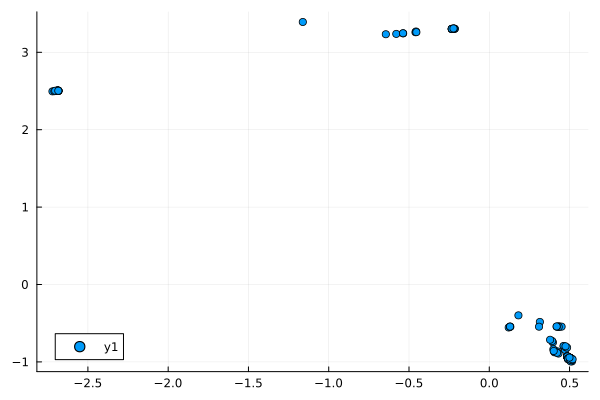

In [44]:
x = infer_x(model, y)

using Plots
scatter(x[:, 1], x[:, 2])

In [9]:
function compute_inverse_blocks(main, sub, super)
        n = length(main)
        block_size = size(main[1], 1)
    
        # Initialize arrays
        S = zeros(block_size, block_size, n-1)
        D = zeros(block_size, block_size, n)
    
        # Create new variables to avoid confusion
        bb = -super
        bbt = -sub
    
        S[:, :, n-1] = bbt[end] * pinv(main[end])
        for i in n-2:-1:1
            S[:, :, i] = bb[i] * pinv(main[i+1] - (S[:, :, i+1] * bbt[i+1]'))
        end
    
        # Compute diagonal blocks D
        D[:, :, 1] = pinv(main[1] - (bb[1] * S[:, :, 1]'))
        for i in 2:n-1
            D[:, :, i] = pinv(main[i] - bbt[i-1]' * D[:, :, i-1] * S[:, :, i]')
        end
        D[:, :, n] = pinv(main[n])*(I + bbt[n-1]' * D[:, :, n-1] * S[:, :, n-1])
    
        # Return the computed diagonal blocks
        return D
    end

z = compute_inverse_blocks(-main, -super, -sub)

2×2×2 Array{Float64, 3}:
[:, :, 1] =
  0.431797  -0.195413
 -0.195413   0.669032

[:, :, 2] =
  0.620824  -0.440515
 -0.440515   1.16198

In [11]:
"""Block Tridiagonal Inverse"""
# function block_tridiagonal_inverse(sub, main, super)
#     # simple checks
#     @assert length(main) == length(sub) + 1
#     @assert length(main) == length(super) + 1
    
#     # Get the size of the blocks
#     n = length(main)
#     block_size = size(main[1], 1)

#     # Initialize arrays with dimensions Txnxn
#     S = zeros(n-1, block_size, block_size)
#     D = zeros(n, block_size, block_size)
#     OD = zeros(n-1, block_size, block_size)

#     # Create new variables to avoid confusion
#     bb = -super
#     bbt = -sub

#     # Compute the S blocks
#     S[n-1, :, :] = bbt[end] * pinv(main[end])
#     for i in n-2:-1:1
#         S[i, :, :] = bb[i] * pinv(main[i+1] - (S[i+1, :, :] * bbt[i+1]'))
#     end

#     # Compute the diagonal blocks D
#     D[1, :, :] = pinv(main[1] - (bb[1] * S[1, :, :]'))
#     for i in 1:n-2
#         D[i+1, :, :] = pinv(main[i+1] - bbt[i+1]' * S[i+1, :, :]') * (I + bbt[i] * D[i, :, :] * S[i, :, :])
#     end
#     D[n, :, :] = pinv(main[n]) * (I + bbt[n-1]' * D[n-1, :, :] * S[n-1, :, :])

#     # Compute the off-diagonal blocks OD
#     for i in 1:n-1
#         OD[i, :, :] = S[i, :, :]' * D[i, :, :]
#     end

#     return D, OD
# end

4×4 Matrix{Float64}:
  0.431797  -0.195413   0.240742  -0.235838
 -0.195413   0.669032  -0.235135   0.528607
  0.240742  -0.235135   0.620824  -0.440515
 -0.235838   0.528607  -0.440515   1.16198